In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski
import os
import ipywidgets as widgets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap
import pprint

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE= 32
CHANNELS= 3
EPOCHS=50

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "colored_images",
    shuffle= True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 3662 files belonging to 5 classes.


AttributeError: 'BatchDataset' object has no attribute 'describe'

In [4]:
class_names= dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [5]:
for image_batch, label_batch in dataset.take(1):
   print (image_batch. shape)
   print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 1 2 3 2 1 2 2 2 2 2 2 1 2 1 2 2 2 0 4 2 2 2 2 2 1 2 1 2]


In [6]:
mild_path=glob.glob(r'gaussian_filtered_images/Mild/*.png')
moderate_path=glob.glob(r'gaussian_filtered_images/Moderate/*.png')
proliferate_dr_path=glob.glob(r'gaussian_filtered_images/Proliferate_DR/*.png')
severe_path=glob.glob(r'gaussian_filtered_images/Severe/*.png')

In [7]:
mild_dir=[]
moderate_dir=[]
no_dr_dir=[]
proliferate_dr_dir=[]
severe_dir=[]
for i in mild_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    mild_dir.append(img)
for i in moderate_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    moderate_dir.append(img)
for i in proliferate_dr_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    proliferate_dr_dir.append(img)
for i in severe_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    severe_dir.append(img)

In [8]:
def data_import(mild_dir,moderate_dir,proliferate_dr_dir,severe_dir):
    df_data_mild = pd.DataFrame({'image':mild_dir, 'label': 'mild'})
    df_data_moderate = pd.DataFrame({'image':moderate_dir, 'label': 'moderate'})
    #df_data_no = pd.DataFrame({'image':no_dr_dir, 'label': 'no_DR'})
    df_data_proliferate = pd.DataFrame({'image':proliferate_dr_dir, 'label': 'proliferate_DR'})
    df_data_severe = pd.DataFrame({'image':severe_dir, 'label': 'severe'})

    
    final_data = [df_data_mild, df_data_moderate,df_data_proliferate,df_data_severe]
    final_data = pd.concat(final_data)
    
    all_data = final_data['image']
    labels = final_data['label']
    all_data=np.stack(all_data,axis=0)
    labels = LabelBinarizer().fit_transform(labels)
    return all_data,labels

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


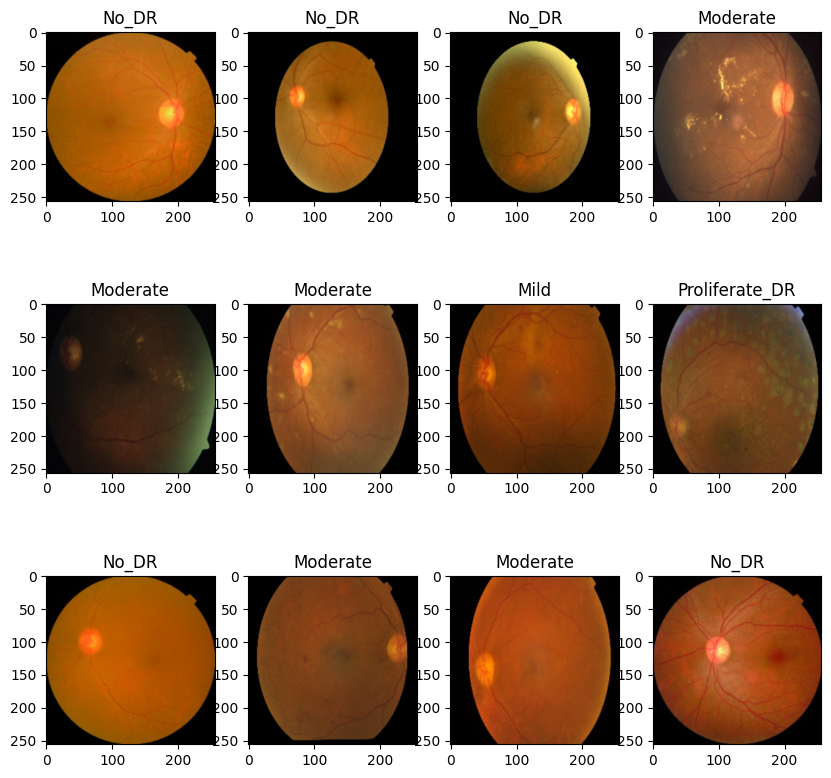

In [43]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

In [44]:
len(dataset)

115

In [ ]:
class_folders=[
    
]

In [61]:
num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_names):
    image_dict[folder.split("/")[-1].split()[0]] = glob.glob(str(dataset) + ".jpg")[:num_sample_images]

pprint.pprint(image_dict)

{'Mild': [], 'Moderate': [], 'No_DR': [], 'Proliferate_DR': [], 'Severe': []}


In [96]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img, thresh_min=155, thresh_max=255):
    return cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]

def getContours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return (contours, hierarchy)

def drawContours(image, contours):
    return cv2.drawContours(image, contours, -1, (255, 0, 0), 0)

def calculateImageFeatures(contours, featcols):
    feat_array = np.zeros((1, len(featcols)), np.float32)
    mmnts =  cv2.moments(contours[0], False)
    for i, k in enumerate(sorted(mmnts.keys())):
        feat_array[0, i] = mmnts[k]
    
    area = cv2.contourArea(contours[0], False)
    
    centroid_x = mmnts['m10']/(mmnts['m00'] + 0.000000000001)
    centroid_y = mmnts['m01']/(mmnts['m00'] + + 0.000000000001)
    arcLength = cv2.arcLength(contours[0], True)
    
    feat_array[0, len(mmnts)] = area
    feat_array[0, len(mmnts)+1] = centroid_x
    feat_array[0, len(mmnts)+2] = centroid_y
    feat_array[0, len(mmnts)+3] = arcLength
    
    return feat_array

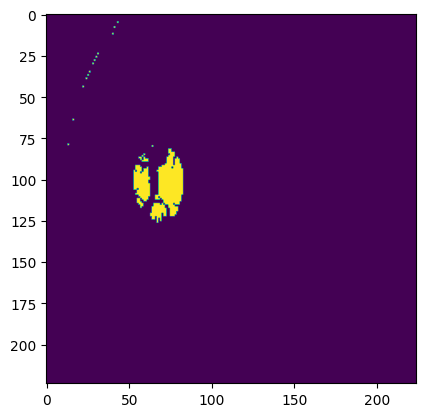

In [106]:
sample_thresh = threshold_image(to_grayscale(cv2.imread("Mild/0a61bddab956.png")))
plt.imshow(sample_thresh)

In [107]:
cnts, h = getContours(sample_thresh)
sample_moments = cv2.moments(cnts[0], False)

feature_cols = list(sorted(sample_moments.keys())) + ["area", "centroidx", "centroidy", "length"]
pprint.pprint(feature_cols)

sample_features = calculateImageFeatures(cnts, feature_cols)
pprint.pprint(sample_features)

['m00',
 'm01',
 'm02',
 'm03',
 'm10',
 'm11',
 'm12',
 'm20',
 'm21',
 'm30',
 'mu02',
 'mu03',
 'mu11',
 'mu12',
 'mu20',
 'mu21',
 'mu30',
 'nu02',
 'nu03',
 'nu11',
 'nu12',
 'nu20',
 'nu21',
 'nu30',
 'area',
 'centroidx',
 'centroidy',
 'length']
array([[ 1.4950000e+02,  1.5378167e+04,  1.5865436e+06,  1.6416654e+08,
         8.5973330e+03,  8.8478969e+05,  9.1326352e+07,  4.9525975e+05,
         5.0993728e+07,  2.8578854e+07,  4.6839844e+03,  4.7103672e+03,
         4.3368900e+02, -6.2079913e+02,  8.5078381e+02, -5.4742841e+02,
        -2.2232857e+01,  2.0957191e-01,  1.7236607e-02,  1.9404212e-02,
        -2.2716851e-03,  3.8065962e-02, -2.0032004e-03, -8.1356506e-05,
         1.4950000e+02,  5.7507248e+01,  1.0286399e+02,  7.6526909e+01]],
      dtype=float32)


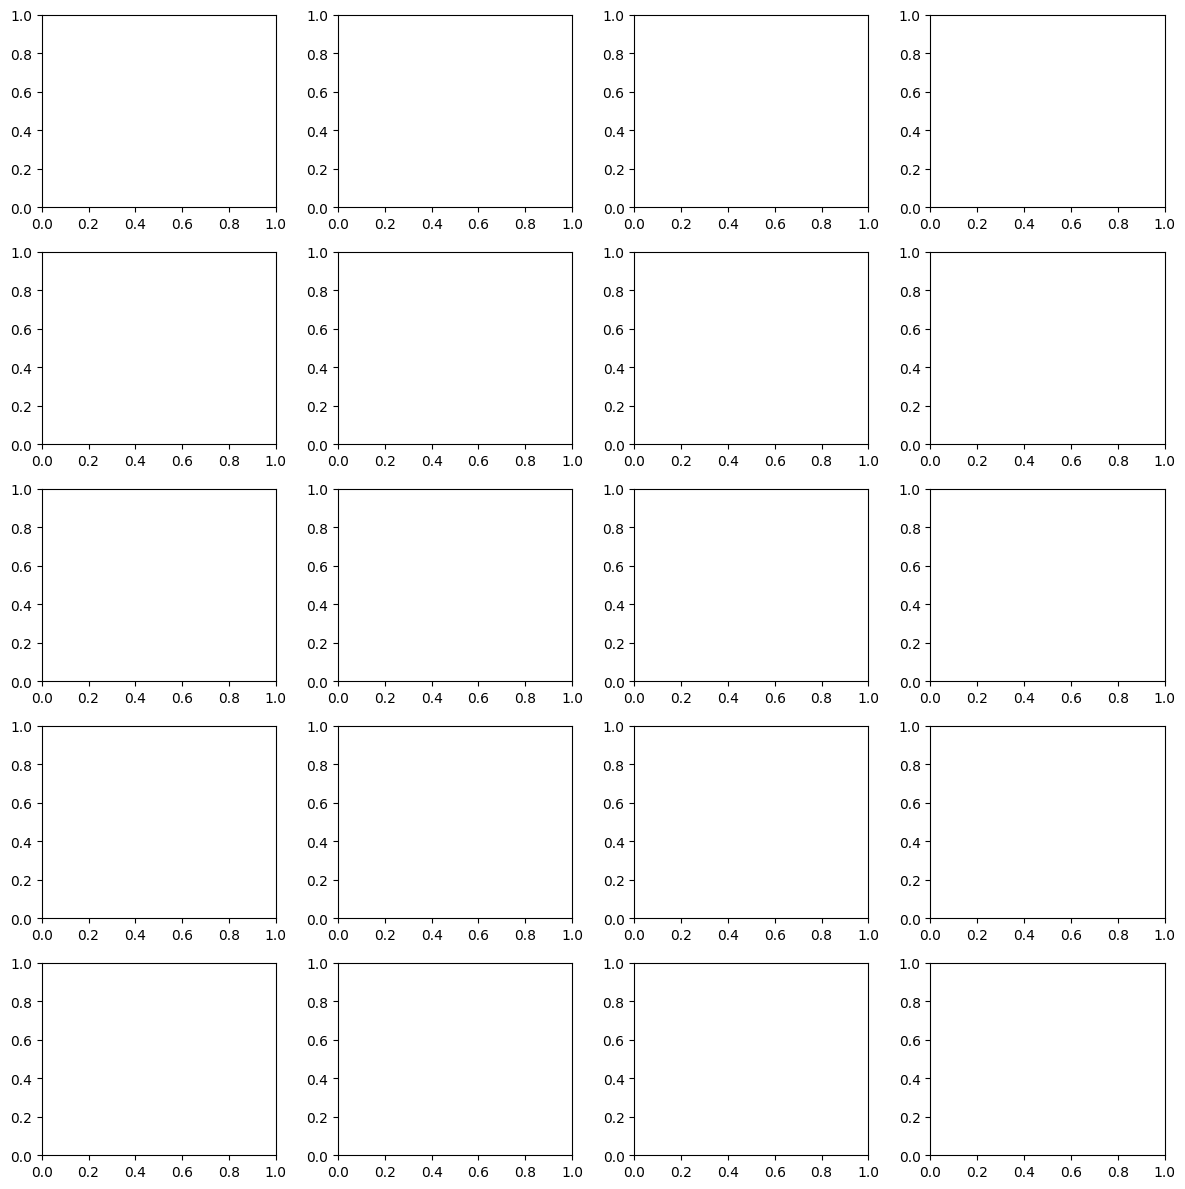

In [108]:
fig, axs = plt.subplots(nrows=5, ncols=num_sample_images*4, figsize=(12, 12))
for i, (k,v) in enumerate(image_dict.items()):
    for j, image_path in enumerate(v):
        img = cv2.imread(image_path)
        gray = to_grayscale(img)
        thresh = threshold_image(gray)
        
        cnts, h = getContours(thresh)
        withConts = drawContours(img.copy(), cnts)
        
        axs[i,j].imshow(img)
        axs[i,j].set_title(k)
        
        axs[i,j+1].imshow(gray, cmap='gray')
        axs[i,j+1].set_title(k + "_gray")
        
        axs[i,j+2].imshow(thresh, cmap='gray')
        axs[i,j+2].set_title(k + "_thresh")
        
        axs[i,j+3].imshow(withConts)
        axs[i,j+3].set_title(k + "_contours")

plt.tight_layout();

In [109]:
classes = list(image_dict.keys())

In [110]:
classwise_feature_dict = {}
classwise_img_dict = {}
error_images = []

In [111]:
classwise_feature_dict = {}
classwise_img_dict = {}
error_images = []


for i, folder in enumerate(class_folders):
    img_class = folder.split("/")[-1].split()[0]
    array_lst = list()
    img_path_lst = list()
    
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")):
        try:
            img = cv2.imread(filename)
            array_lst.append(calculateImageFeatures(getContours(threshold_image(to_grayscale(img).copy()).copy())[0], feature_cols))
            img_path_lst.append(filename)
        except Exception as err:
            error_images.append((img_class,filename))
            print(err)
            raise err
            break

    all_class_features = np.vstack(array_lst)
    classwise_feature_dict[img_class] = all_class_features
    classwise_img_dict[img_class] = img_path_lst
    print(f"Image Class: {img_class}")
    print(f"Total Images: {all_class_features.shape[0]}")
    print("--------------------------------------------")

ValueError: need at least one array to concatenate